## Analysis of datasets + stats for compressing with FPDE
This notebook contains methods for passing a .shp-file (or directory) and obtaining stats for the FPDE properties of the compression. Stats include the number of chunks, number of deltas within each chunk, average number of vertices, and a distribution of the overhead within the format.

## Evaluating one shape-file
The methods take one .shp-file and return the stats. Multiple calls can be merged further done if a set of .shp-files are to be analysed.

In [5]:
import jsonlines
import glob
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import folium
import tqdm
import shapely
import random
import os
from shapely.wkt import loads
from algos.fpd_extended_lib.cfg import *
import numpy as np
import re
import seaborn as sns
from algos.alg_fpd_extended import FpdExtended

In [6]:
#df = gpd.read_file('data/ne_10m_admin_1_states_provinces.shp')
#df = gpd.read_file('data/sweden-latest-free/gis_osm_buildings_a_free_1.shp')
#df = gpd.read_file('data/sweden-latest-free/gis_osm_natural_a_free_1.shp')
MAX_ITER = 100000

def load_shp(file_name, DO_VERTEX_CNT, accumulative=False):
    df = gpd.read_file(file_name)
    print("Count of entries:", len(df))
    df = df[df.type != "Point"]
    print("---", file_name, "---")
    print("Count of entries (no points):", len(df))
    if len(df) == 0:
        return pd.DataFrame(), []
    shapes = df.geometry
    if MAX_ITER != -1 and not accumulative:
        shapes = shapes.sample(n=MAX_ITER, replace=True)

    vertex_cnt = []
    if DO_VERTEX_CNT:
        for s in tqdm.tqdm(shapes):
            vertex_cnt.append(shapely.get_num_coordinates(s))

        vertex_cnt = np.array(vertex_cnt)
        if len(vertex_cnt) != 0:
            res = f"Total: {len(vertex_cnt)}, avg: {round(np.average(vertex_cnt), 2)}, std: {round(np.std(vertex_cnt), 2)}, median: {np.median(vertex_cnt)}, min: {np.min(vertex_cnt)}, max: {np.max(vertex_cnt)}, #>=25: {(vertex_cnt >= 25).sum()} ({round(100 * (vertex_cnt >= 25).sum() / len(vertex_cnt), 2)}), #>=100: {(vertex_cnt >= 100).sum()} ({round(100 * (vertex_cnt >= 100).sum() / len(vertex_cnt), 2)}), #>=200: {(vertex_cnt >= 200).sum()} ({round(100 * (vertex_cnt >= 200).sum() / len(vertex_cnt), 2)}), #>=500: {(vertex_cnt >= 500).sum()} ({round(100 * (vertex_cnt >= 500).sum() / len(vertex_cnt), 2)}), #>=1000: {(vertex_cnt >= 1000).sum()} ({round(100 * (vertex_cnt >= 1000).sum() / len(vertex_cnt), 2)})"
            print(res)
            with open('vertex_cnt_for_datasets.txt', 'a') as f:
                f.write(f"{file_name}\n{res}\n\n")
        else:
            print("No geometries (except Point(s)) in dataset.")
    return shapes, vertex_cnt

In [7]:
from algos.fpd_extended_lib.decompress import decode_header
from algos.fpd_extended_lib import cfg

def fpde_analyze(shapes, collected_stats=None):
    stats = pd.DataFrame(columns=["No Comp Size", "Comp Size", "Comp Factor", "Delta Size", "Vertex Cnt", "Chunk Cnt", "Avg Vertices in Chk", "Std Vertices in Chk", "Median Vertices in Chk", "Min Vertices in Chk", "Max Vertices in Chk"])
    stats_distribution = pd.DataFrame()
    stats_max_values = pd.DataFrame()
    if collected_stats != None:
        stats, stats_distribution, stats_max_values = collected_stats
    alg = FpdExtended()

    for idx, s in enumerate(tqdm.tqdm(shapes)):
        bin = alg.compress(s)[1]
        wkb_len = len(shapely.to_wkb(s))
        bin_len = len(bin)
        coords_len = shapely.get_num_coordinates(s)

        chks, _, overhead_stats = alg.get_chunks(bin, include_ring_start=False, verbose=True)
        cfg.offset = 0
        d_size, geom_type = decode_header(bin)
        chk_cnt = len(chks)
        chk_lens = list(map(lambda x: len(x), chks))

        stats.loc[len(stats)] = [wkb_len, bin_len, wkb_len / bin_len, d_size, coords_len, chk_cnt, np.average(chk_lens), np.std(chk_lens), np.median(chk_lens), np.min(chk_lens), np.max(chk_lens)]

        # Analysis of space
        max_values, distrb = overhead_stats
        theoretical_size = sum(distrb.values())
        distrb = pd.DataFrame(distrb, index=[idx])
        stats_distribution = pd.concat([stats_distribution, distrb])
        stats_max_values = pd.concat([stats_max_values, pd.DataFrame(max_values, index=[idx])])

        DISPLAY_PER_SHAPE_STATS = False
        if DISPLAY_PER_SHAPE_STATS:
            display(distrb)
            print("Size (calculated, rounded to byte, real):", theoretical_size, f"({((theoretical_size + 7) & (-8))})", bin_len * 8)
            print("Max Values:", dict(max_values))

    print("---- AVERAGE COMPRESSED SHAPE ----")
    pd.set_option('display.precision', 2)
    display(stats.mean())
    print("Global: Min Vertices in Chk / Max Vertices in Chk", np.min(stats['Min Vertices in Chk']), np.max(stats['Max Vertices in Chk']))

    print("---- DATA DISTRIBUTION ----")
    final_distribution = stats_distribution.mean()
    display(final_distribution)
    normalized_distribution = final_distribution.apply(lambda x: 100 * x / sum(final_distribution))
    display(normalized_distribution)

    print("---- TO SET MANUAL PARAMS ----")
    final_max_values = stats_max_values.max()
    min_bits = final_max_values.apply(lambda x: required_bits(x))
    min_bits = min_bits.add_prefix("Bits ")
    display(pd.concat([final_max_values, min_bits]))
    return stats, stats_distribution, stats_max_values, normalized_distribution

In [8]:
DATASET = 'data/sweden-latest-free/gis_osm_railways_free_1.shp'
DATASET = 'data/sweden-latest-free'
#DATASET = 'data/sweden-latest-free/gis_osm_natural_free_1.shp'
#DATASET = "data/sweden-latest-free/gis_osm_buildings_a_free_1.shp"
#DATASET = "data/sweden-latest-free/gis_osm_roads_free_1.shp"
#DATASET = 'data/ne_10m_admin_1_states_provinces.shp'
ONLY_VERTEX_CNT = False # Can be used if only the amount of vertices in the dataset is required

if DATASET.endswith(".shp"):
    files = [DATASET]
else:
    files = glob.glob(DATASET + '/*.shp')
files = ["data/sweden-latest-free/gis_osm_buildings_a_free_1.shp", "data/sweden-latest-free/gis_osm_roads_free_1.shp", "data/china-latest-free/gis_osm_water_a_free_1.shp", "data/ne_10m_admin_1_states_provinces.shp"]
#files = ["data/sweden-latest-free/gis_osm_railways_free_1.shp", "data/ne_10m_admin_1_states_provinces.shp"]
#files = ['QGIS/Report_Visualizations.shp', 'QGIS/Intersection_Tricky_Cases.shp']
#files = ["data/sweden-latest-free/gis_osm_pois_free_1.shp", "QGIS/Report_Visualizations.shp"]

legends = ["Sweden Buildings", "Sweden Roads", "China Water", "Country Borders"]

all_vertex_cnts = []
stats = pd.DataFrame()
collected_stats = None
all_shapes = []
ACCUMULATE_STATS = False # Should separate .shp-files be merged?
ACCUMULATE_NAME = "Sweden All"

for i, f in enumerate(tqdm.tqdm(files, disable=True)):
    shapes, vertex_cnt = load_shp(f, ONLY_VERTEX_CNT or ACCUMULATE_STATS, ACCUMULATE_STATS)
    all_shapes.append(shapes)
    all_vertex_cnts.append([f, vertex_cnt])
    if not ONLY_VERTEX_CNT and not ACCUMULATE_STATS:
        stats_chunks, stats_distribution, stats_max_values, normalized_distribution = fpde_analyze(shapes)
        df = pd.DataFrame(normalized_distribution, columns=['Percent'])
        df['Dataset'] = legends[i] if not ACCUMULATE_STATS else ACCUMULATE_NAME
        stats = pd.concat([stats, df])

# Now know how to weight the sampling
if not ONLY_VERTEX_CNT and ACCUMULATE_STATS:
    for i, f in enumerate(tqdm.tqdm(files, disable=True)):
        shapes = all_shapes[i].sample(n=int(MAX_ITER * len(all_vertex_cnts[i][1]) / sum([len(cnt[1]) for cnt in all_vertex_cnts])), replace=True)
        stats_chunks, stats_distribution, stats_max_values, normalized_distribution = fpde_analyze(shapes, collected_stats)
        collected_stats = stats_chunks, stats_distribution, stats_max_values
    df = pd.DataFrame(normalized_distribution, columns=['Percent'])
    df['Dataset'] = ACCUMULATE_NAME
    stats = pd.concat([stats, df])

Count of entries: 2827275
--- data/sweden-latest-free/gis_osm_buildings_a_free_1.shp ---
Count of entries (no points): 2827275


100%|██████████| 100000/100000 [09:20<00:00, 178.54it/s]

---- AVERAGE COMPRESSED SHAPE ----


No Comp Size              113.73
Comp Size                  64.38
Comp Factor                 1.72
Delta Size                 12.25
Vertex Cnt                  6.29
Chunk Cnt                   1.01
Avg Vertices in Chk         5.23
Std Vertices in Chk         0.02
Median Vertices in Chk      5.23
Min Vertices in Chk         5.21
Max Vertices in Chk         5.26
dtype: float64

Global: Min Vertices in Chk / Max Vertices in Chk 1.0 113.0
---- DATA DISTRIBUTION ----


Global Header Bitsize       1.60e+01
Bounding Box Bitsize        1.28e+02
Intersection Bitsize        1.61e+02
Poly Ring Cnt Bitsize       1.20e-03
Ring Chk Cnt Bitsize        1.50e+01
Chk Deltas Cnt Bitsize      2.01e+01
Full Coordinates Bitsize    6.43e+01
Deltas Bitsize              1.06e+02
dtype: float64

Global Header Bitsize       3.14e+00
Bounding Box Bitsize        2.51e+01
Intersection Bitsize        3.15e+01
Poly Ring Cnt Bitsize       2.35e-04
Ring Chk Cnt Bitsize        2.95e+00
Chk Deltas Cnt Bitsize      3.94e+00
Full Coordinates Bitsize    1.26e+01
Deltas Bitsize              2.08e+01
dtype: float64

---- TO SET MANUAL PARAMS ----


Poly Ring Cnt Max            1
Ring Chk Cnt Max            11
Chk Deltas Cnt Max         112
Bits Poly Ring Cnt Max       2
Bits Ring Chk Cnt Max        4
Bits Chk Deltas Cnt Max      7
dtype: int64

Count of entries: 1904260
--- data/sweden-latest-free/gis_osm_roads_free_1.shp ---
Count of entries (no points): 1904260


100%|██████████| 100000/100000 [10:14<00:00, 162.86it/s]

---- AVERAGE COMPRESSED SHAPE ----


No Comp Size              211.93
Comp Size                  92.32
Comp Factor                 1.78
Delta Size                 13.73
Vertex Cnt                 12.68
Chunk Cnt                   1.08
Avg Vertices in Chk        10.74
Std Vertices in Chk         0.79
Median Vertices in Chk     10.62
Min Vertices in Chk         9.99
Max Vertices in Chk        11.72
dtype: float64

Global: Min Vertices in Chk / Max Vertices in Chk 1.0 498.0
---- DATA DISTRIBUTION ----


Global Header Bitsize        16.00
Bounding Box Bitsize        128.00
Intersection Bitsize        169.68
Poly Ring Cnt Bitsize         0.00
Ring Chk Cnt Bitsize          0.00
Chk Deltas Cnt Bitsize       21.51
Full Coordinates Bitsize     68.84
Deltas Bitsize              331.70
dtype: float64

Global Header Bitsize        2.17
Bounding Box Bitsize        17.40
Intersection Bitsize        23.06
Poly Ring Cnt Bitsize        0.00
Ring Chk Cnt Bitsize         0.00
Chk Deltas Cnt Bitsize       2.92
Full Coordinates Bitsize     9.36
Deltas Bitsize              45.08
dtype: float64

---- TO SET MANUAL PARAMS ----


Poly Ring Cnt Max            0
Ring Chk Cnt Max             0
Chk Deltas Cnt Max         497
Bits Poly Ring Cnt Max       1
Bits Ring Chk Cnt Max        1
Bits Chk Deltas Cnt Max      9
dtype: int64

Count of entries: 366881
--- data/china-latest-free/gis_osm_water_a_free_1.shp ---
Count of entries (no points): 366881


100%|██████████| 100000/100000 [12:28<00:00, 133.67it/s]

---- AVERAGE COMPRESSED SHAPE ----


No Comp Size              949.53
Comp Size                 274.06
Comp Factor                 2.80
Delta Size                 14.17
Vertex Cnt                 58.49
Chunk Cnt                   1.89
Avg Vertices in Chk        24.10
Std Vertices in Chk         5.27
Median Vertices in Chk     22.78
Min Vertices in Chk        19.51
Max Vertices in Chk        34.15
dtype: float64

Global: Min Vertices in Chk / Max Vertices in Chk 1.0 7699.0
---- DATA DISTRIBUTION ----


Global Header Bitsize         16.00
Bounding Box Bitsize         128.00
Intersection Bitsize         274.23
Poly Ring Cnt Bitsize          0.14
Ring Chk Cnt Bitsize          17.05
Chk Deltas Cnt Bitsize        37.85
Full Coordinates Bitsize     121.11
Deltas Bitsize              1594.39
dtype: float64

Global Header Bitsize       7.31e-01
Bounding Box Bitsize        5.85e+00
Intersection Bitsize        1.25e+01
Poly Ring Cnt Bitsize       6.53e-03
Ring Chk Cnt Bitsize        7.79e-01
Chk Deltas Cnt Bitsize      1.73e+00
Full Coordinates Bitsize    5.53e+00
Deltas Bitsize              7.28e+01
dtype: float64

---- TO SET MANUAL PARAMS ----


Poly Ring Cnt Max           123
Ring Chk Cnt Max           2264
Chk Deltas Cnt Max         7698
Bits Poly Ring Cnt Max        7
Bits Ring Chk Cnt Max        12
Bits Chk Deltas Cnt Max      13
dtype: int64

Count of entries: 4596
--- data/ne_10m_admin_1_states_provinces.shp ---
Count of entries (no points): 4596


100%|██████████| 100000/100000 [20:58<00:00, 79.43it/s]

---- AVERAGE COMPRESSED SHAPE ----


No Comp Size              4537.15
Comp Size                 1700.52
Comp Factor                  2.59
Delta Size                  20.54
Vertex Cnt                 281.98
Chunk Cnt                   10.27
Avg Vertices in Chk         38.21
Std Vertices in Chk         24.88
Median Vertices in Chk      30.31
Min Vertices in Chk         18.32
Max Vertices in Chk         99.47
dtype: float64

Global: Min Vertices in Chk / Max Vertices in Chk 1.0 15952.0
---- DATA DISTRIBUTION ----


Global Header Bitsize          16.00
Bounding Box Bitsize          128.00
Intersection Bitsize         1345.98
Poly Ring Cnt Bitsize           9.90
Ring Chk Cnt Bitsize           28.12
Chk Deltas Cnt Bitsize        205.31
Full Coordinates Bitsize      656.99
Deltas Bitsize              11210.25
dtype: float64

Global Header Bitsize        0.12
Bounding Box Bitsize         0.94
Intersection Bitsize         9.90
Poly Ring Cnt Bitsize        0.07
Ring Chk Cnt Bitsize         0.21
Chk Deltas Cnt Bitsize       1.51
Full Coordinates Bitsize     4.83
Deltas Bitsize              82.43
dtype: float64

---- TO SET MANUAL PARAMS ----


Poly Ring Cnt Max              3
Ring Chk Cnt Max             591
Chk Deltas Cnt Max         15951
Bits Poly Ring Cnt Max         3
Bits Ring Chk Cnt Max         10
Bits Chk Deltas Cnt Max       14
dtype: int64

In [150]:
import pickle
# with open('data/sweden_all_fpde_analysis_overhead.pkl', 'wb') as f:
#     pickle.dump(stats, f)

# import pickle
# with open('data/fpde_analysis_overhead.pkl', 'wb') as f:
#     pickle.dump(stats, f)

with open('data/sweden_all_fpde_analysis_overhead.pkl', 'rb') as f:
    stats_sweden = pickle.load(f)

with open('data/fpde_analysis_overhead.pkl', 'rb') as f:
    stats = pickle.load(f)

In [151]:
stats = pd.concat([stats.iloc[:16], stats_sweden, stats.iloc[16:]], axis=0)

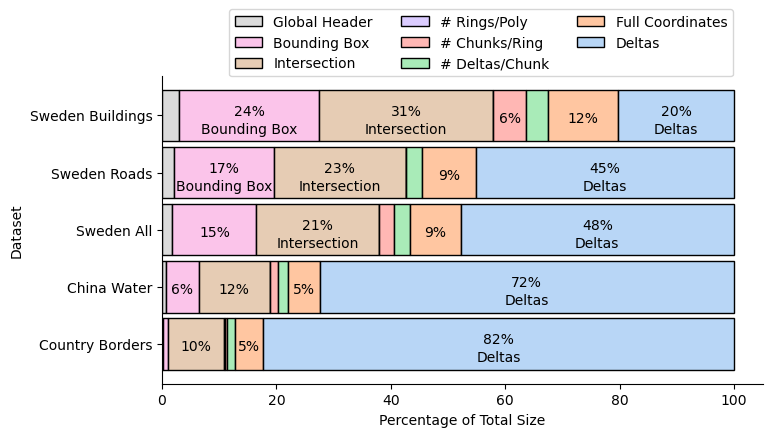

,Type,Percent,Dataset
0,Global Header,3.04e+00,Sweden Buildings
1,Bounding Box,2.43e+01,Sweden Buildings
2,Intersection,3.05e+01,Sweden Buildings
3,# Rings/Poly,2.51e-04,Sweden Buildings
4,# Chunks/Ring,5.72e+00,Sweden Buildings
5,# Deltas/Chunk,3.82e+00,Sweden Buildings
6,Full Coordinates,1.22e+01,Sweden Buildings
7,Deltas,2.03e+01,Sweden Buildings
8,Global Header,2.17e+00,Sweden Roads
9,Bounding Box,1.74e+01,Sweden Roads


In [152]:
df = stats.reset_index()
df = df.rename(columns={'index': 'Type'})
df['Type'] = df['Type'].apply(lambda x: x[0:-8])
df['Type'] = df['Type'].replace('Poly Ring Cnt', '# Rings/Poly')
df['Type'] = df['Type'].replace('Ring Chk Cnt', '# Chunks/Ring')
df['Type'] = df['Type'].replace('Chk Deltas Cnt', '# Deltas/Chunk')

fig, axe = plt.subplots(figsize=(7.75, 4))

df_rev = df.groupby('Dataset', sort=False).apply(lambda x: x.iloc[::-1]).reset_index(drop=True)

sns.histplot(data=df_rev, y='Dataset', hue='Type', weights='Percent', multiple='stack', ax=axe, legend=False, palette='pastel', shrink=0.9)

# Iterate through each dataset
for i, dataset in enumerate(df['Dataset'].unique()):
    dataset_df = df[df['Dataset'] == dataset]
    
    # Iterate through each set of containers for the dataset
    for j, c in enumerate(axe.containers):
        # Get the corresponding values for the bars in the current set of containers
        values = dataset_df.iloc[j]['Percent']  # Convert the value to a list
        rect = c[i]
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        percent_y = -2
        if values > 15:
            # Add the text label
            axe.annotate(df.iloc[j]["Type"], xy=(x + width / 2, y + height / 2), xytext=(0, -10),
                            textcoords="offset points", ha='center', va='center')
            percent_y = 3
            
        if values > 4:
            # Add the value annotation
            axe.annotate(f'{values:.0f}%', xy=(x + width / 2, y + height / 2), xytext=(0, percent_y),
                            textcoords="offset points", ha='center', va='center')



axe.set_xlabel('Percentage of Total Size')


# Show the plot
plt.legend(df['Type'][:8], bbox_to_anchor=(0.1, 0.975),
          ncol=3, fancybox=True, shadow=False)
#plt.tight_layout()
axe.spines['top'].set_visible(False)
axe.spines['right'].set_visible(False)
axe.spines['bottom'].set_visible(True)
axe.spines['left'].set_visible(True)

plt.show()
display(df)

In [ ]:
import pickle
# with open('data/sweden_all_fpde_analysis.pkl', 'wb') as f:
#     pickle.dump(all_vertex_cnts, f)
# with open('data/fpde_analysis.pkl', 'wb') as f:
#     pickle.dump(all_vertex_cnts, f)

with open('data/sweden_all_fpde_analysis.pkl', 'rb') as f:
        all_vertex_cnts_sweden = pickle.load(f)

with open('data/fpde_analysis.pkl', 'rb') as f:
        all_vertex_cnts = pickle.load(f)

legends_sweden = ["Landuse (A)", "Buildings (A)", "Waterways", "Water (A)", "Places (A)", "Natural (A)", "Pofw (A)", "Traffic (A)", "Railways", "Transport (A)", "Pois (A)", "Roads"]
legends = legends_sweden
all_vertex_cnts = all_vertex_cnts_sweden

In [ ]:
# Merge Sweden into Sweden All
import itertools

all_vertex_cnts.insert(2, ["Sweden All", list(itertools.chain.from_iterable([c for f, c in all_vertex_cnts_sweden if len(c) != 0]))])
legends.insert(2, "Sweden All")

KeyboardInterrupt: 

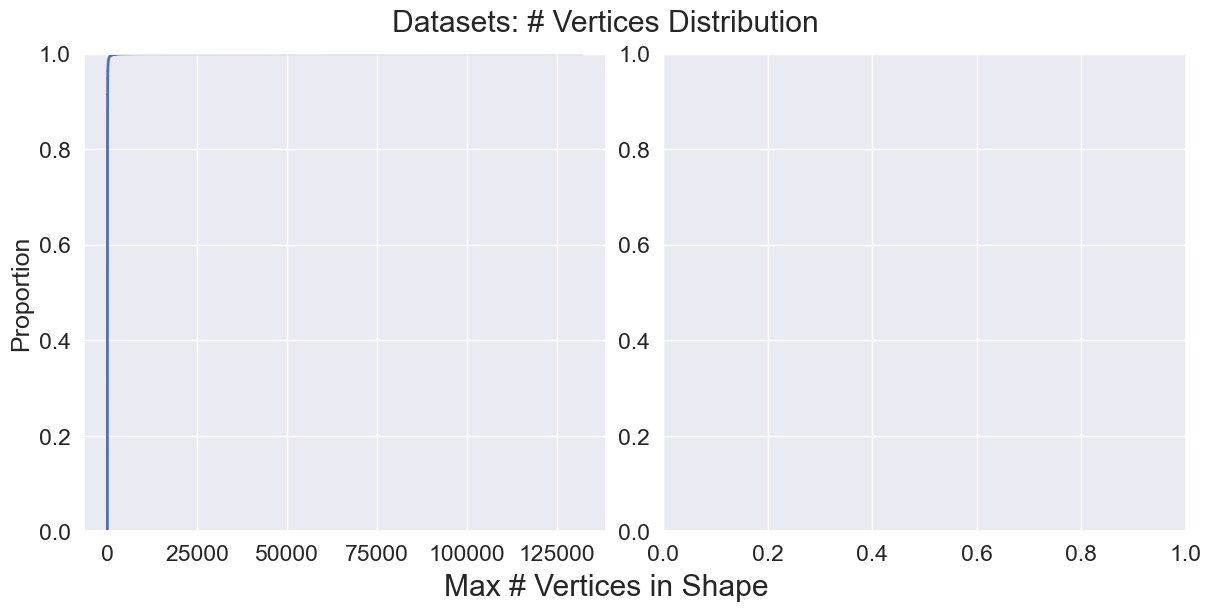

In [ ]:
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
sns.set(font_scale=1.5)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), constrained_layout=True)
axes = axes.flatten()
fig.supxlabel("Max # Vertices in Shape")
fig.suptitle("Datasets: # Vertices Distribution") # (Sweden All)


for f, v in all_vertex_cnts:
    if len(v) == 0:
        continue
    sns.ecdfplot(v, ax=axes[0], linewidth = 2)
    #sns.displot(v, kind="kde")

legend = fig.legend(legends, loc='center right')
axes[0].set_xscale('log')
axes[0].set_xlim(1, 10000)
formatter = ScalarFormatter()
formatter.set_scientific(False) 
axes[0].xaxis.set_major_formatter(formatter)
#axes[0].set_xlabel("Max # Verticies in Shape")
axes[0].set_ylabel("Dataset Proportion")

# Weighted
for f, counts in all_vertex_cnts:
    if len(counts) == 0:
        continue
    weighted = [s for s in counts for _ in range(s)]
    sns.ecdfplot(weighted, ax=axes[1], linewidth = 2)
axes[1].set_xscale('log')
axes[1].set_xlim(1, 75000)
axes[1].xaxis.set_major_formatter(formatter)
axes[1].set_ylabel("File Size Proportion")

#fig.tight_layout()
plt.show()